# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *

import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
hdb = pd.read_csv('../../data/raw/01_hdb_resale_transactions.csv')
hdb.head()

,block,street_name,town,postal_code,month,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,latitude,longitude,cbd_dist,min_dist_mrt
0,174,ANG MO KIO AVENUE 4,ANG MO KIO,560174,2015-01,3 ROOM,07 TO 09,60.0,Improved,1986,255000.0,1.375097,103.837619,10296.855750,1096.947897
1,541,ANG MO KIO AVENUE 10,ANG MO KIO,560541,2015-01,3 ROOM,01 TO 03,68.0,New Generation,1981,275000.0,1.373922,103.855621,10065.227930,847.235690
2,163,ANG MO KIO AVENUE 4,ANG MO KIO,560163,2015-01,3 ROOM,01 TO 03,69.0,New Generation,1980,285000.0,1.373552,103.838169,10118.831550,1176.742184
3,446,ANG MO KIO AVENUE 10,ANG MO KIO,560446,2015-01,3 ROOM,01 TO 03,68.0,New Generation,1979,290000.0,1.367761,103.855357,9383.300907,682.205473
4,557,ANG MO KIO AVENUE 10,ANG MO KIO,560557,2015-01,3 ROOM,07 TO 09,68.0,New Generation,1980,290000.0,1.371626,103.857736,9825.917255,953.047695


# Data Exploration

In [3]:
hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194240 entries, 0 to 194239
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   block                194240 non-null  object 
 1   street_name          194240 non-null  object 
 2   town                 194240 non-null  object 
 3   postal_code          194240 non-null  int64  
 4   month                194240 non-null  object 
 5   flat_type            194240 non-null  object 
 6   storey_range         194240 non-null  object 
 7   floor_area_sqm       194240 non-null  float64
 8   flat_model           194240 non-null  object 
 9   lease_commence_date  194240 non-null  int64  
 10  resale_price         194240 non-null  float64
 11  latitude             194240 non-null  float64
 12  longitude            194240 non-null  float64
 13  cbd_dist             194240 non-null  float64
 14  min_dist_mrt         194240 non-null  float64
dtypes: float64(6), in

In [5]:
hdb.describe()

,postal_code,floor_area_sqm,lease_commence_date,resale_price,latitude,longitude,cbd_dist,min_dist_mrt
count,194240.000000,194240.000000,194240.000000,1.942400e+05,194240.000000,194240.000000,194240.000000,194240.000000
mean,559367.576117,97.384379,1994.774820,4.752727e+05,1.367260,103.841397,12418.365399,826.191306
std,190231.706479,24.072589,13.448988,1.629553e+05,0.042700,0.071485,4403.239962,461.936681
min,50004.000000,31.000000,1966.000000,1.400000e+05,1.270380,103.644248,592.121638,36.079525
25%,510139.000000,82.000000,1984.000000,3.570000e+05,1.336746,103.778927,9671.510513,473.819855
50%,560534.000000,94.000000,1995.000000,4.420000e+05,1.366658,103.846243,13311.128120,739.284414
75%,730022.000000,112.000000,2004.000000,5.600000e+05,1.395108,103.899455,15459.885140,1096.721051
max,825195.000000,280.000000,2019.000000,1.500000e+06,1.457071,103.987804,23298.462280,3496.402761


In [6]:
hdb.isna().sum()

block                  0
street_name            0
town                   0
postal_code            0
month                  0
flat_type              0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
latitude               0
longitude              0
cbd_dist               0
min_dist_mrt           0
dtype: int64

In [7]:
hdb.duplicated().any()

True

array([[<Axes: title={'center': 'postal_code'}>,
        <Axes: title={'center': 'floor_area_sqm'}>,
        <Axes: title={'center': 'lease_commence_date'}>],
       [<Axes: title={'center': 'resale_price'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'cbd_dist'}>,
        <Axes: title={'center': 'min_dist_mrt'}>, <Axes: >]], dtype=object)

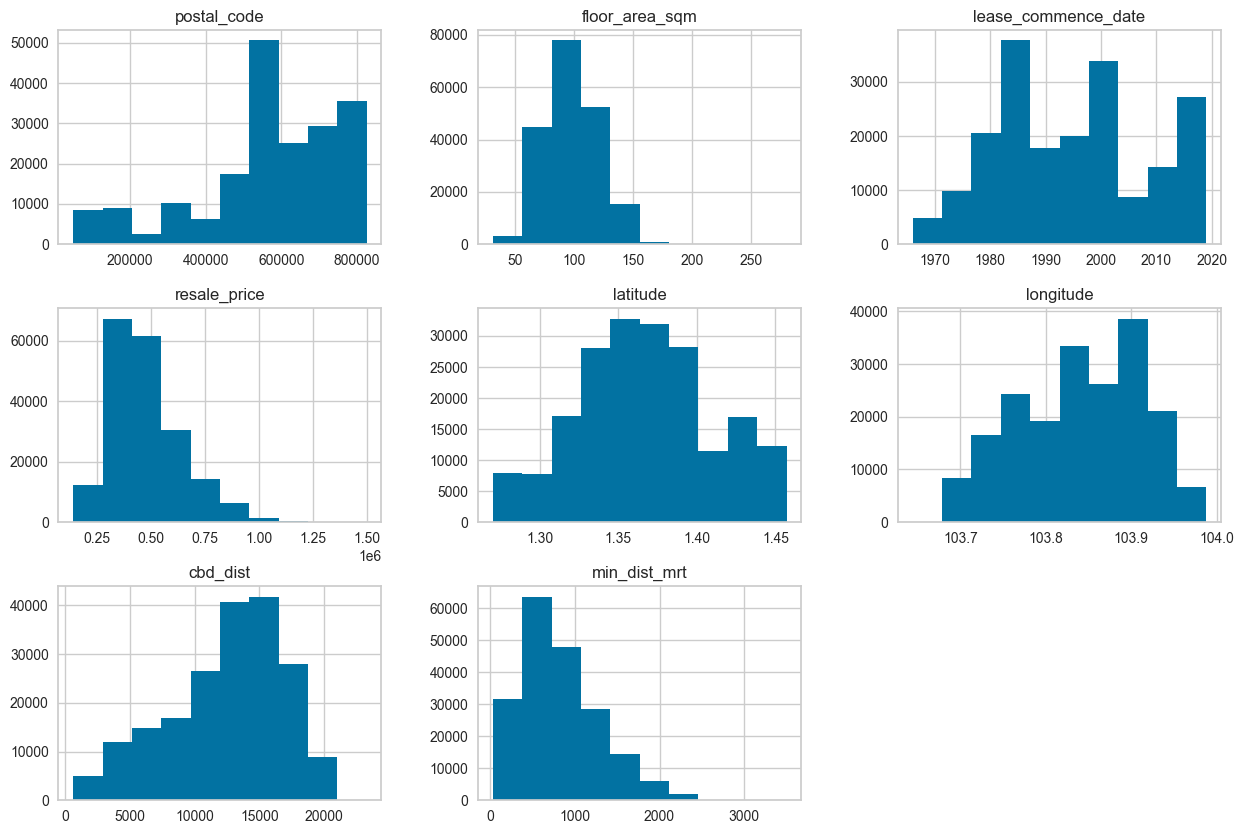

In [8]:
hdb.hist(figsize=(15,10))

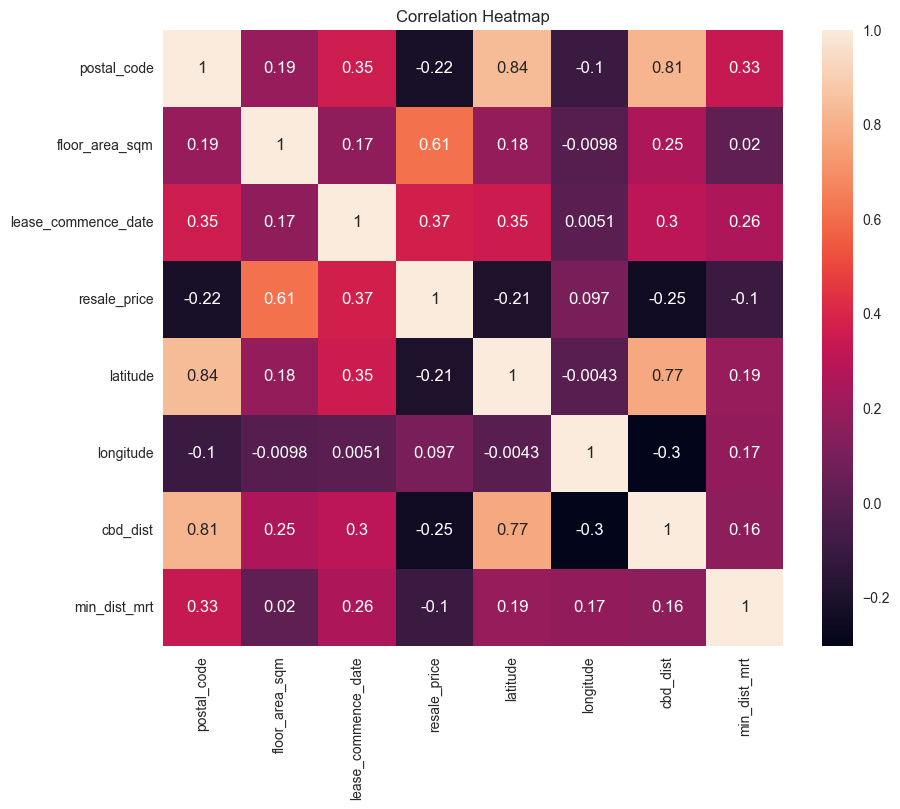

In [9]:
# Select only the integer and float columns
numeric_columns = hdb.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='rocket')

# Customize the plot
plt.title('Correlation Heatmap')
plt.show()

From the correlation heatmap, we can see that significant features with positive correlation with resale price are mainly floor area sqm and lease commence data whereas postal code, latitude, cbd dist are negatively correlated. Furthermore, there may be multicollinearity issues for postal code cbd_dist and latitude.

<Axes: xlabel='floor_area_sqm', ylabel='resale_price'>

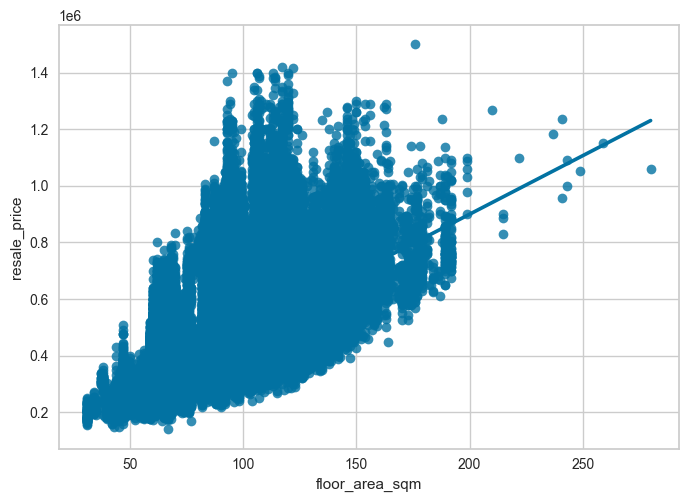

In [10]:
sns.regplot(x='floor_area_sqm',y='resale_price',data=hdb)

From this regression plot, it supports the correlation matrix as it shows that the greater the floor area sqm, the greater the resale_price.

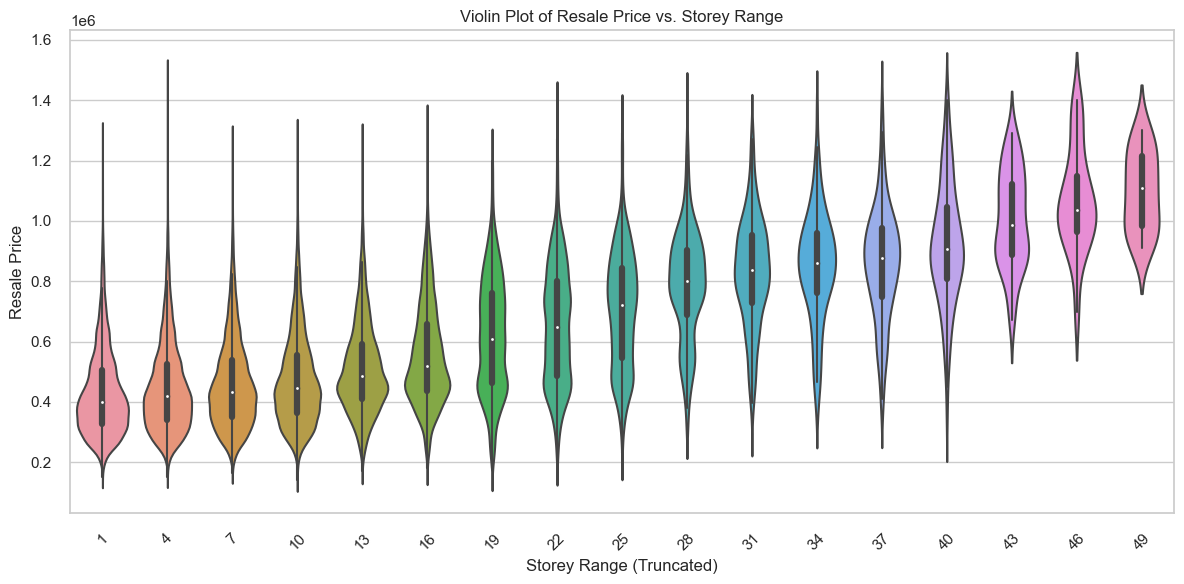

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Truncate 'storey_range' to the first two digits and convert to numerical values
hdb['storey_number'] = hdb['storey_range'].str[:2].astype(int)

# Set the style of seaborn
sns.set(style="whitegrid")

# Create the violin plot
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
sns.violinplot(x='storey_number', y='resale_price', data=hdb, order=sorted(hdb['storey_number'].unique()))

# Customize the plot
plt.title('Violin Plot of Resale Price vs. Storey Range')
plt.ylabel('Resale Price')
plt.xlabel('Storey Range (Truncated)')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout for better spacing

# Display the plot
plt.show()


From the violin plot, it tells us that generally, higher floors will lead to more expensive prices except with a few exceptions.

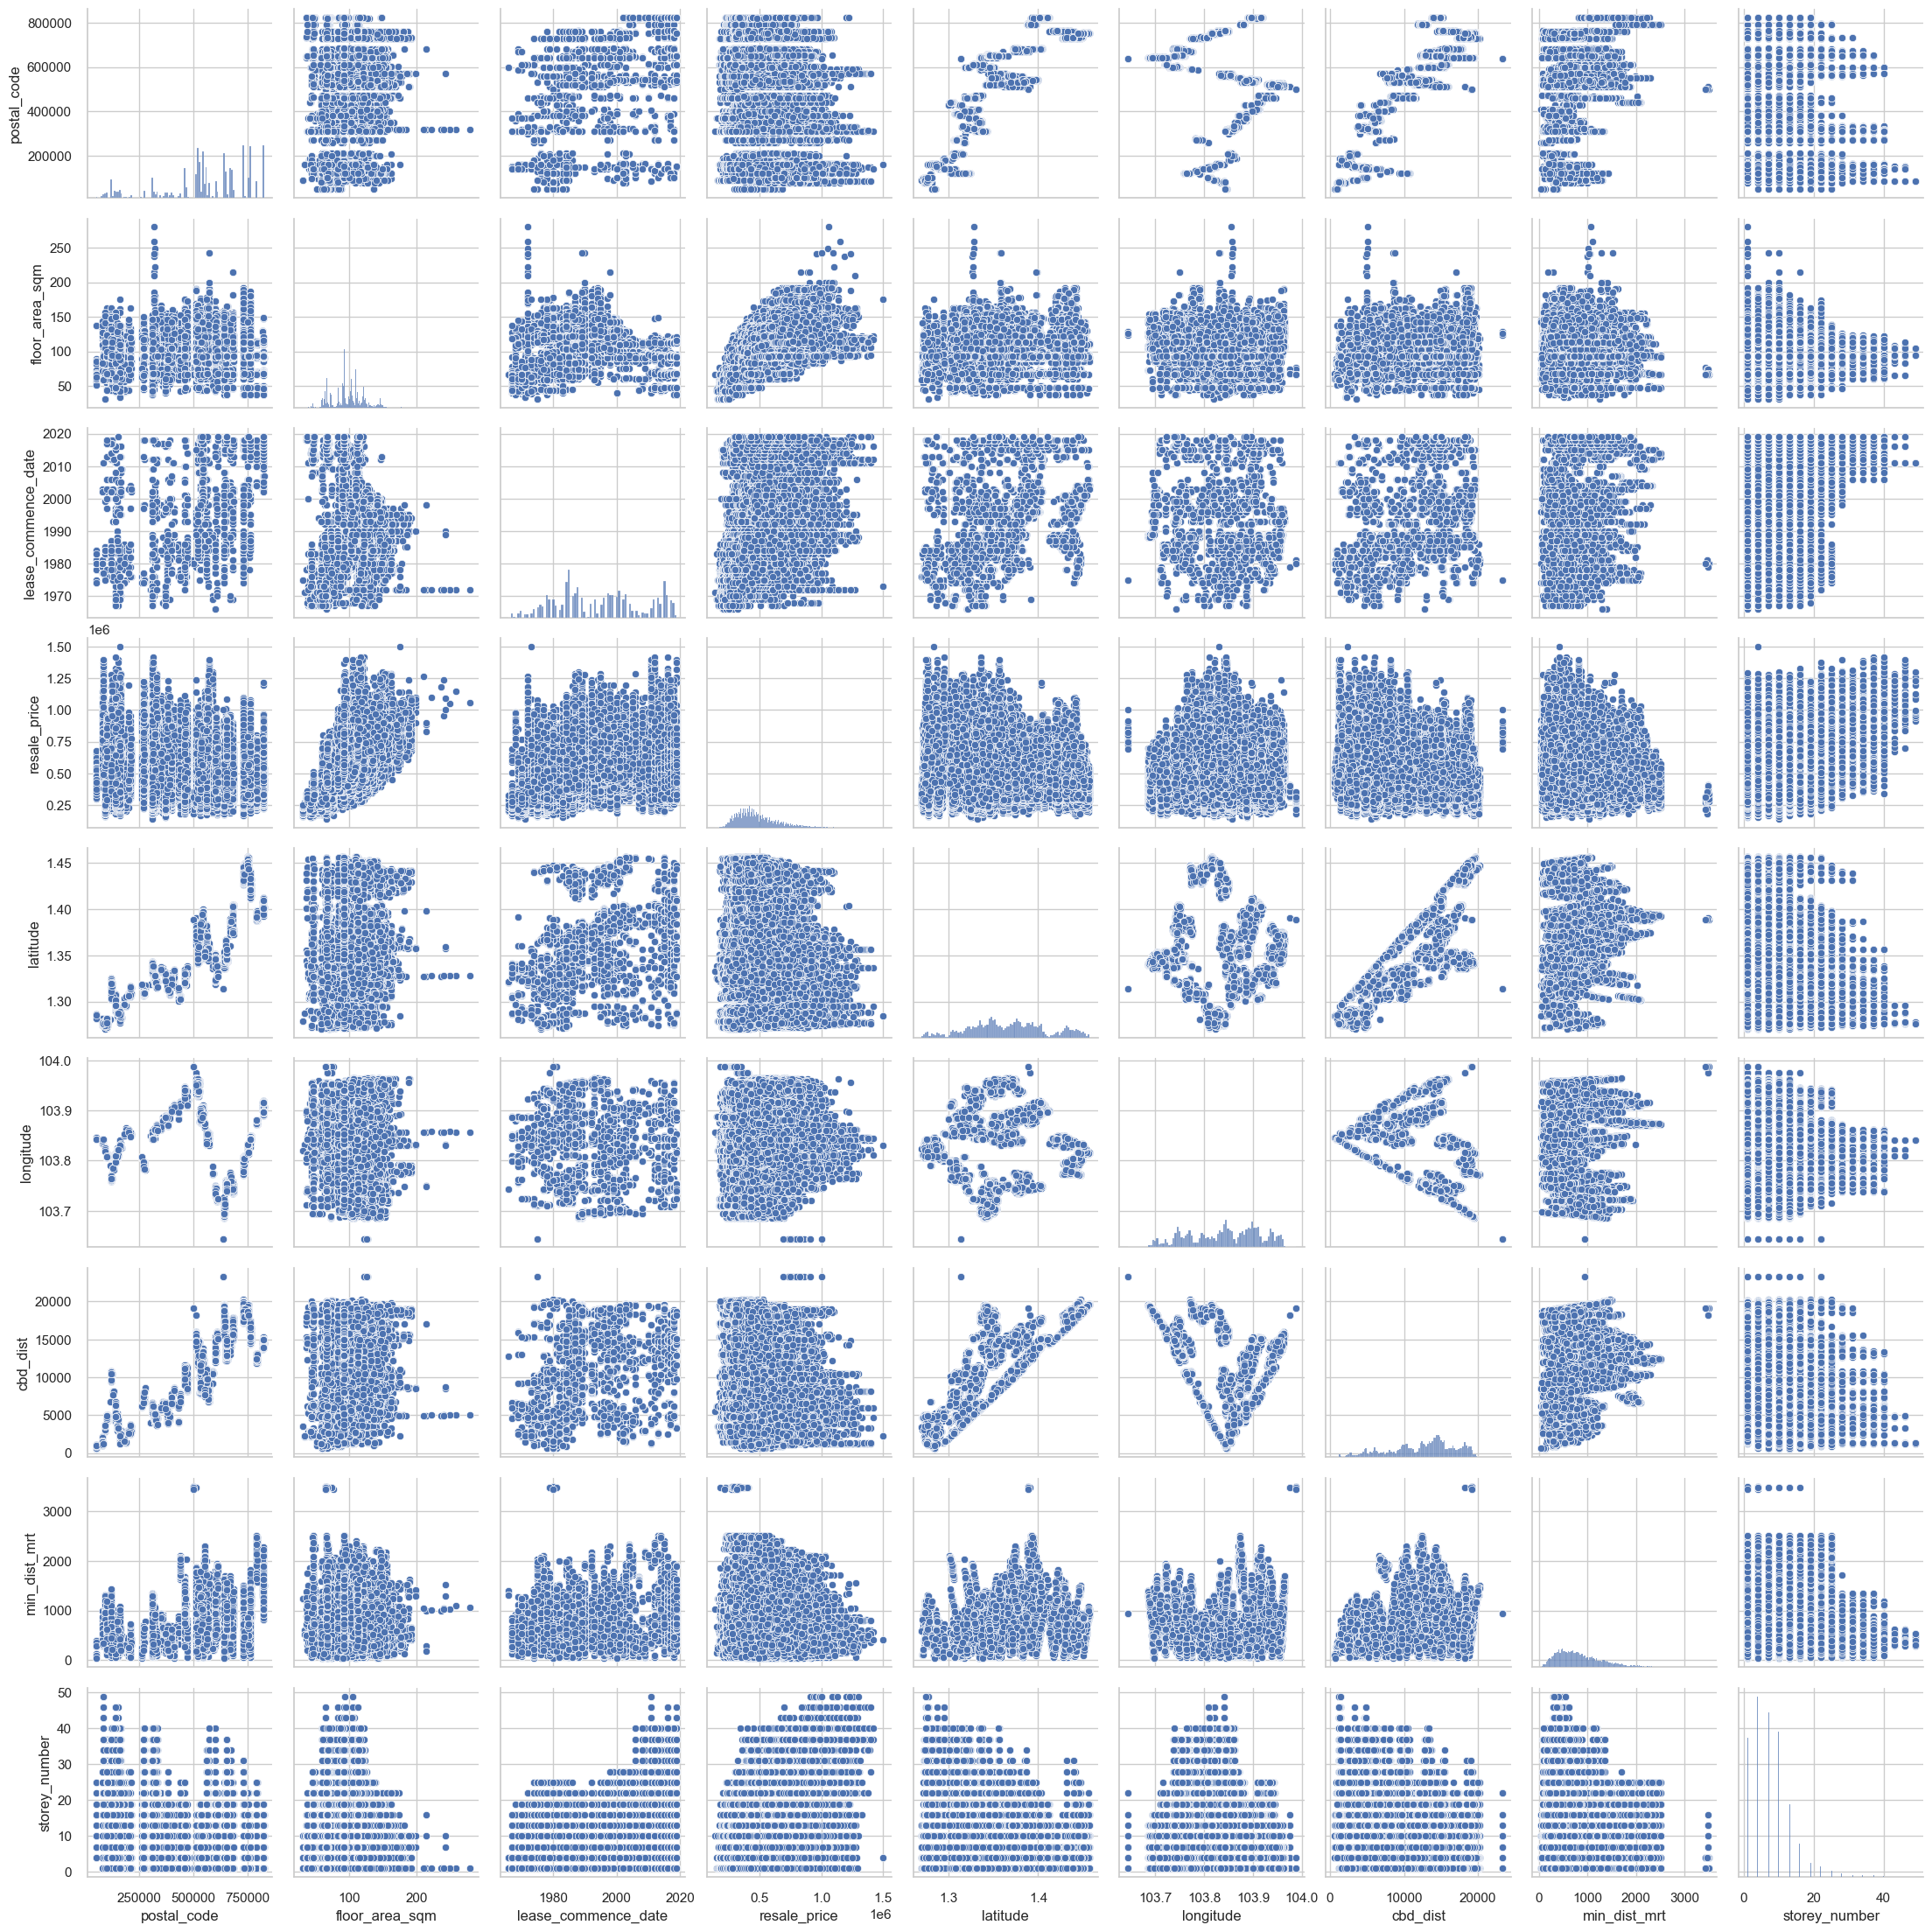

In [12]:
sns.pairplot(data=hdb)

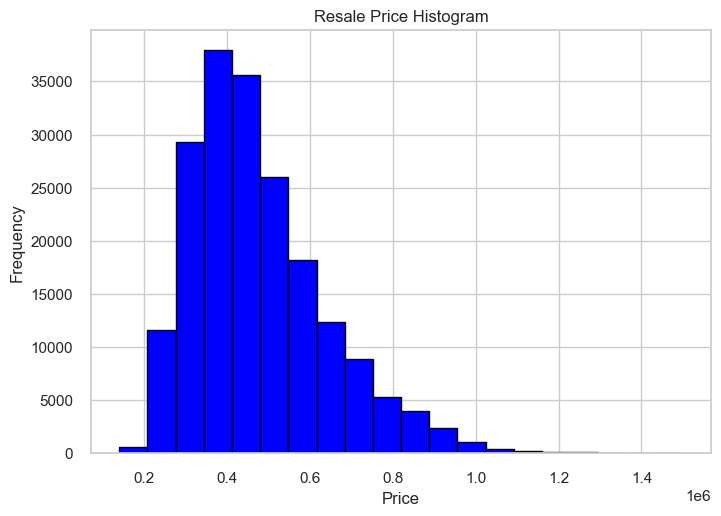

In [13]:
prices = hdb['resale_price']

# Create the histogram
plt.hist(prices, bins=20, color='blue', edgecolor='black')

# Customize the plot
plt.title('Resale Price Histogram')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)

# Display the plot
plt.show()

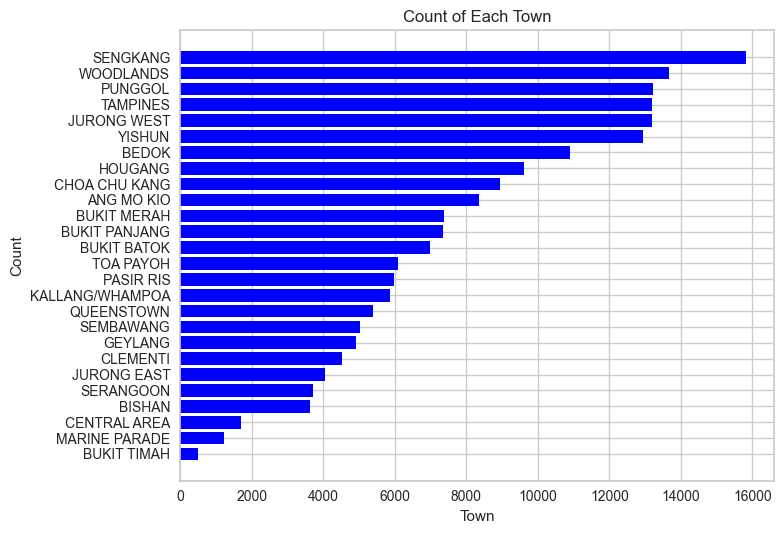

In [108]:
town_counts = hdb['town'].value_counts().sort_values(ascending=True)

# Create a sorted bar chart
plt.barh(town_counts.index, town_counts.values, color='blue')

# Customize the plot
plt.title('Count of Each Town')
plt.xlabel('Town')
plt.ylabel('Count')

# Display the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [112]:
avg_price

town
ANG MO KIO         434379.932811
BEDOK              436532.508630
BISHAN             655344.918902
BUKIT BATOK        431903.911754
BUKIT MERAH        585093.963880
BUKIT PANJANG      454210.845660
BUKIT TIMAH        720732.244653
CENTRAL AREA       663069.053200
CHOA CHU KANG      440173.741895
CLEMENTI           503243.807080
GEYLANG            458023.035939
HOUGANG            467055.410167
JURONG EAST        441952.622233
JURONG WEST        423685.246088
KALLANG/WHAMPOA    536142.588254
MARINE PARADE      541177.025306
PASIR RIS          528915.698614
PUNGGOL            495145.029460
QUEENSTOWN         594432.672302
SEMBAWANG          433718.369706
SENGKANG           476449.838889
SERANGOON          511517.995133
TAMPINES           499859.027969
TOA PAYOH          500367.896026
WOODLANDS          425890.091333
YISHUN             403526.866886
Name: resale_price, dtype: float64

The histogram tells us that hdb prices are mainly around 400k

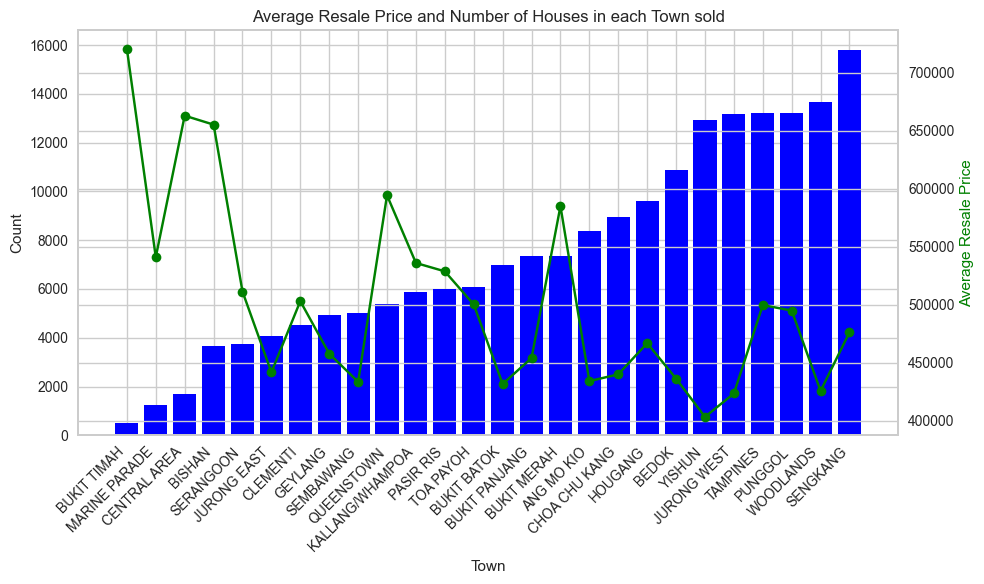

In [114]:

# Calculate town counts
town_counts = hdb['town'].value_counts().sort_values(ascending=True)

# Create a figure and axis for the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for town counts
ax1.bar(town_counts.index, town_counts.values, color='blue')
ax1.set_ylabel('Count')
ax1.set_xlabel('Town')
ax1.set_title('Average Resale Price and Number of Houses in each Town sold')

# Explicitly set x-axis labels to follow the order of town counts
ax1.set_xticks(town_counts.index)
ax1.set_xticklabels(town_counts.index, rotation=45, ha='right')

# Create a secondary y-axis for the line chart
ax2 = ax1.twinx()

# Calculate average price per town
avg_price = hdb.groupby('town')['resale_price'].mean()

# Line chart for average resale price
ax2.plot(town_counts.index, avg_price[town_counts.index], marker='o', color='green')
ax2.set_ylabel('Average Resale Price')
ax2.yaxis.label.set_color('green')

# Show the plot
plt.tight_layout()
plt.show()


From this line and bar chart, we can see that most houses sold come from sengkang while the most expensive houses are from bukit timah.

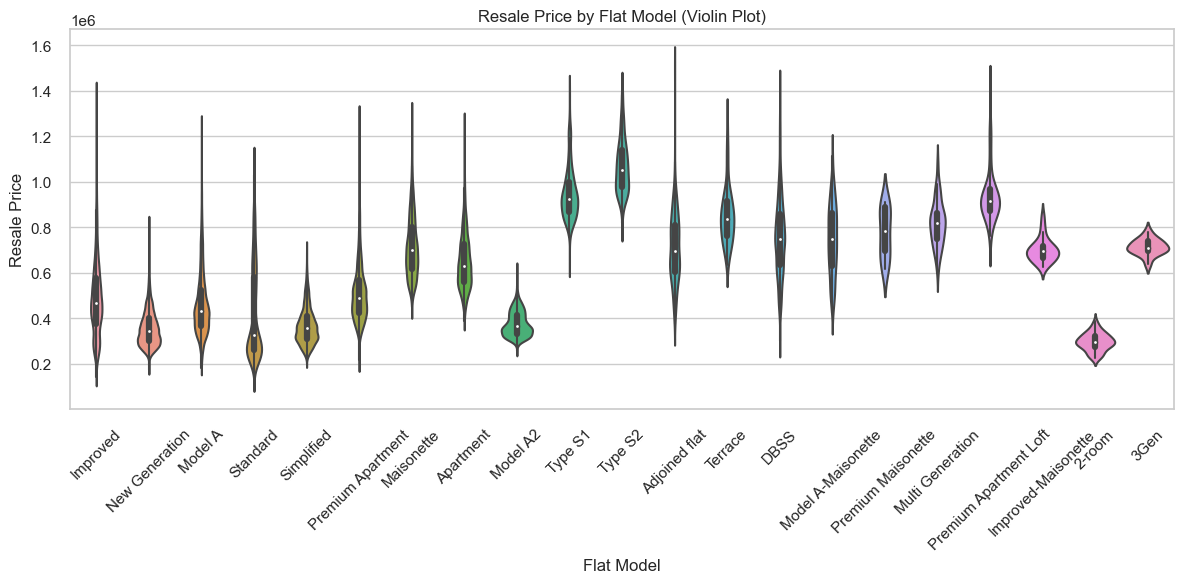

In [15]:
# Create the violin plot
plt.figure(figsize=(12, 6))  # Adjust figure size (width, height)
sns.violinplot(x='flat_model', y='resale_price', data=hdb)

# Customize the plot
plt.title('Resale Price by Flat Model (Violin Plot)')
plt.xlabel('Flat Model')
plt.ylabel('Resale Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better spacing

# Display the plot
plt.show()

From this violin plot, we can see that Type S2 houses on average are more expensive. Adjoined Flats can be the most expensive while standard flats can be the cheapest. Models like Model A2, Improved-Maisonette, 2-room and 3Gen does not have big distribution of prices.

# Data Preprocessing

In [3]:
# Remove duplicates based on all columns
hdb_nodup = hdb.drop_duplicates()

# Display the shape before and after removing duplicates
print("Shape before removing duplicates:", hdb.shape)
print("Shape after removing duplicates:", hdb_nodup.shape)

Shape before removing duplicates: (194240, 15)
Shape after removing duplicates: (193877, 15)


In [4]:
# Convert the 'month' column to datetime type
hdb_nodup['month'] = pd.to_datetime(hdb_nodup['month'], format='%Y-%m')

In [5]:
hdb_sampled = hdb_nodup.sample(frac=0.6, random_state=123)

### Pycaret Processing
1. target is resale price
2. train size of 0.8
3. transformation and normalize set to true to normalize data
4. remove outliers
5. 10 kfold
6. ignore features not required
- block number can be repeated throughout different towns and it will not indicate a higher or lower price
- latitude and longitude not required as users will not always know the exact coordinates of their house
7. bin postal code since it should be categorical and to avoid too many unique values
8. Explicity set month to as date feature

In [6]:
hdbsetup = setup(data=hdb_sampled, target='resale_price', train_size=0.8,transformation=True,normalize=True,session_id=123, 
               log_experiment=True,experiment_name='hdb_nohydra', remove_outliers=True, fold=10,
               ignore_features=['block', 'latitude','longitude'], bin_numeric_features = ['postal_code'],
                 date_features=['month']
        )


,Description,Value
0,Session id,123
1,Target,resale_price
2,Target type,Regression
3,Original data shape,"(116326, 15)"
4,Transformed data shape,"(111673, 56)"
5,Transformed train set shape,"(88407, 56)"
6,Transformed test set shape,"(23266, 56)"
7,Ignore features,3
8,Numeric features,5
9,Date features,1


2023/08/21 17:22:24 INFO mlflow.tracking.fluent: Experiment with name 'hdb_nohydra' does not exist. Creating a new experiment.


In [7]:
#Print ordinal, numeric and categorical features
print(f'Ordinal features: {hdbsetup._fxs["Ordinal"]}')
print(f'Numeric features: {hdbsetup._fxs["Numeric"]}')
print(f'Categorical features: {hdbsetup._fxs["Categorical"]}')
print(f'Date features: {hdbsetup._fxs["Date"]}')

Ordinal features: {}
Numeric features: ['postal_code', 'floor_area_sqm', 'lease_commence_date', 'cbd_dist', 'min_dist_mrt']
Categorical features: ['street_name', 'town', 'flat_type', 'storey_range', 'flat_model']
Date features: ['month']


In [14]:
df = hdbsetup.get_config('dataset_transformed')
df

,street_name,town,postal_code,month_year,month_month,month_day,flat_type_5 ROOM,flat_type_4 ROOM,flat_type_3 ROOM,flat_type_EXECUTIVE,...,flat_model_Premium Maisonette,flat_model_2-room,flat_model_Multi Generation,flat_model_Premium Apartment Loft,flat_model_Improved-Maisonette,flat_model_3Gen,lease_commence_date,cbd_dist,min_dist_mrt,resale_price
54587,1.873926,1.165734e-15,-1.249667,-0.877080,1.283510,9.094947e-13,1.741757,-0.87434,-0.567079,-0.277237,...,-0.008899,-0.012585,-0.021008,-0.023788,-0.012585,-0.01009,9.459100e-14,-1.533001,-0.933537,878000.0
219,0.049652,-1.332268e-15,0.407602,-1.644070,-1.763353,9.094947e-13,-0.574133,1.14372,-0.567079,-0.277237,...,-0.008899,-0.012585,-0.021008,-0.023788,-0.012585,-0.01009,-1.598721e-13,0.235990,-0.948722,435000.0
146222,0.343312,1.110223e-15,1.329460,0.765280,0.746502,9.094947e-13,-0.574133,1.14372,-0.567079,-0.277237,...,-0.008899,-0.012585,-0.021008,-0.023788,-0.012585,-0.01009,3.259615e-13,0.230614,1.200219,500000.0
89827,1.317287,1.443290e-15,-0.456816,-0.074501,0.185321,9.094947e-13,-0.574133,1.14372,-0.567079,-0.277237,...,-0.008899,-0.012585,-0.021008,-0.023788,-0.012585,-0.01009,-1.446065e-13,-1.119424,-1.280012,422000.0
84645,1.525972,2.109424e-15,-1.249667,-0.074501,-0.720166,9.094947e-13,-0.574133,1.14372,-0.567079,-0.277237,...,-0.008899,-0.012585,-0.021008,-0.023788,-0.012585,-0.01009,-2.210454e-13,-1.674507,-0.533044,428000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183096,-1.164996,-1.443290e-15,-0.456816,1.643949,-1.391671,9.094947e-13,-0.574133,-0.87434,1.763423,-0.277237,...,-0.008899,-0.012585,-0.021008,-0.023788,-0.012585,-0.01009,-2.364220e-13,-0.894637,-0.387885,440000.0
27422,-0.816138,-1.110223e-15,-0.456816,-1.264926,0.185321,9.094947e-13,-0.574133,-0.87434,1.763423,-0.277237,...,-0.008899,-0.012585,-0.021008,-0.023788,-0.012585,-0.01009,-1.446065e-13,-0.463705,-0.267151,306000.0
193033,-1.075576,-1.221245e-15,1.329460,1.643949,-0.106571,9.094947e-13,-0.574133,1.14372,-0.567079,-0.277237,...,-0.008899,-0.012585,-0.021008,-0.023788,-0.012585,-0.01009,2.974287e-13,1.550671,-0.000162,520000.0
31035,1.394682,3.219647e-15,-1.944066,-1.264926,0.746502,9.094947e-13,-0.574133,-0.87434,1.763423,-0.277237,...,-0.008899,-0.012585,-0.021008,-0.023788,-0.012585,-0.01009,2.544631e-13,-1.103480,0.003522,496000.0


# Model

In [9]:
# compare baseline models
selected = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,24108.2570,1136455767.6581,33706.5460,0.9574,0.0675,0.0515,4.2200
et,Extra Trees Regressor,22418.1440,1138768644.1415,33717.7901,0.9573,0.0650,0.0472,26.4910
rf,Random Forest Regressor,22605.0390,1164175661.5401,34107.5199,0.9564,0.0648,0.0473,30.1460
dt,Decision Tree Regressor,30738.6329,2136283409.5140,46207.7311,0.9199,0.0890,0.0644,3.1050
knn,K Neighbors Regressor,36241.6773,2869922816.0000,53565.9691,0.8924,0.1003,0.0741,4.7120
gbr,Gradient Boosting Regressor,38690.1639,2926311666.2748,54092.3726,0.8903,0.1066,0.0823,11.1350
lr,Linear Regression,51391.7864,4433394257.7041,66582.6551,0.8338,0.1634,0.1156,4.4960
ridge,Ridge Regression,54453.3115,5041200268.2309,70999.5081,0.8110,0.1650,0.1218,2.5640
br,Bayesian Ridge,54452.5293,5041269156.4593,70999.9932,0.8110,0.1650,0.1218,3.1070
lasso,Lasso Regression,54453.2998,5041205356.5423,70999.5439,0.8110,0.1650,0.1218,4.0770


In [10]:
# check the final params of selected model

selected.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 123,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [11]:
tuned_best = tune_model(selected, return_tuner=True) 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,19499.4885,774933069.7650,27837.6197,0.9714,0.0567,0.0419
1,20178.5509,819766574.1623,28631.5660,0.9695,0.0587,0.0435
2,19543.1054,760792738.3208,27582.4716,0.9718,0.0559,0.0421
3,20011.8827,851102867.5598,29173.6674,0.9682,0.0574,0.0430
4,20046.1613,800366678.1658,28290.7525,0.9703,0.0565,0.0426
5,19508.0790,809829245.3253,28457.4989,0.9688,0.0562,0.0418
6,19663.1297,768261108.2007,27717.5235,0.9708,0.0565,0.0425
7,19719.7555,771373936.3518,27773.6194,0.9709,0.0563,0.0423
8,19726.2036,772230088.2627,27789.0282,0.9710,0.0566,0.0424


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [12]:
tuned_best

(LGBMRegressor(bagging_fraction=0.6, bagging_freq=2, feature_fraction=0.4,
               min_child_samples=41, min_split_gain=0.9, n_estimators=260,
               num_leaves=70, random_state=123, reg_alpha=2, reg_lambda=3),
 RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                    estimator=Pipeline(memory=FastMemory(location=C:\Users\ruiji\AppData\Local\Temp\joblib),
                                       steps=[('date_feature_extractor',
                                               TransformerWrapper(include=['month'],
                                                                  transformer=ExtractDateTimeFeatures())),
                                              ('numerical_imputer',
                                               TransformerWrapper(include=['postal_code',
                                                                           'floor_area_sqm'...
                                         'actual_estimator__num_leaves

In [18]:
best_tuned = tuned_best[0]

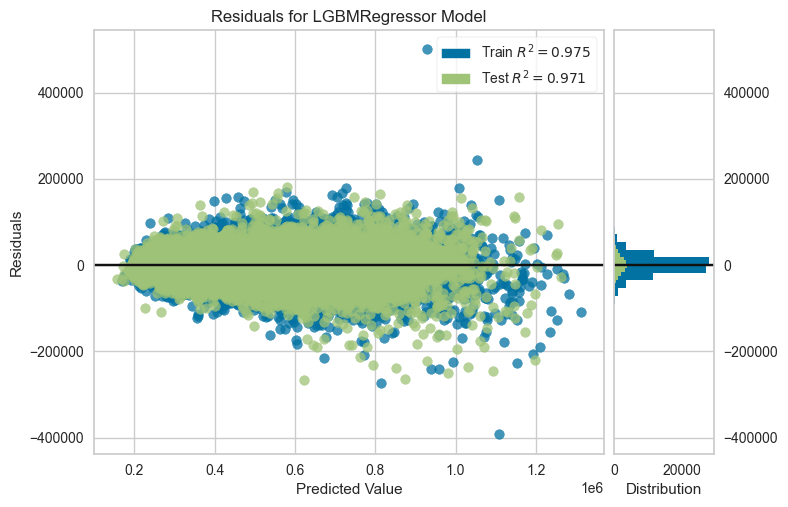

In [20]:
# We can also check the diagnostics and a few other analysis plots using the plot_model function.
# plot residuals
plot_model(best_tuned, plot = 'residuals')

In [21]:
# use evaluate_model to navigate all analysis plot
evaluate_model(best_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Prediction

In [22]:
# predict on test set
hdb_pred = predict_model(best_tuned)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,19816.3023,775608387.8293,27849.7466,0.9713,0.0567,0.0425


In [23]:
# show predictions df
hdb_pred.head()

,street_name,town,postal_code,month,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,cbd_dist,min_dist_mrt,resale_price,prediction_label
8176,CHOA CHU KANG AVENUE 4,CHOA CHU KANG,680451,2015-06-01,4 ROOM,16 TO 18,104.0,Premium Apartment,2000,16757.539062,1134.232910,330000.0,366643.822339
121975,PUNGGOL DRIVE,PUNGGOL,822666,2020-11-01,4 ROOM,16 TO 18,93.0,Premium Apartment,2016,14941.489258,1559.379517,495000.0,516760.886936
176303,JURONG WEST STREET 64,JURONG WEST,643677,2022-11-01,5 ROOM,13 TO 15,110.0,Premium Apartment,2008,17685.521484,756.288330,528000.0,577877.874419
135799,CLEMENTI AVENUE 4,CLEMENTI,123311,2021-05-01,4 ROOM,34 TO 36,80.0,DBSS,2014,10385.429688,553.353577,770888.0,765152.723046
53108,WOODLANDS STREET 32,WOODLANDS,730345,2017-10-01,4 ROOM,04 TO 06,104.0,Model A,1995,18309.177734,684.972534,355000.0,338843.420961


## Save Pipeline

In [71]:
# finalize the model
final_best = finalize_model(best_tuned)

# save model to disk
# save_model(final_best, 'hdb_pipeline_nohydra')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\ruiji\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['floor_area_sqm',
                                              'lease_commence_date', 'cbd_dist',
                                              'min_dist_mrt',
                                              'Transaction_Year'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['town', 'flat_type',
                                              'storey_range', 'flat_model',
                                              'Tr...
                                     transformer=TargetEncoder(cols=['town'],
                                                               handle_missing='return_nan'))),
                 ('remove_outliers',
                  TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
       

In [72]:
# load pipeline
loaded_best_pipeline = load_model('hdb_pipeline_nohydra')
loaded_best_pipeline


Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\ruiji\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['floor_area_sqm',
                                             'lease_commence_date', 'cbd_dist',
                                             'min_dist_mrt',
                                             'Transaction_Year'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['town', 'flat_type',
                                             'storey_range', 'flat_model',
                                             'Tr...
                                    transformer=TargetEncoder(cols=['town'],
                                                              handle_missing='return_nan'))),
                ('remove_outliers',
                 TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 GradientBoostingRegressor(random_state=123))])

## Register model with mlflow

In [73]:
!mlflow ui

^C


In [84]:
# # Calculate evaluation metrics
# y_true = hdb_pred['resale_price']
# y_pred = hdb_pred['prediction_label']
# mae = mean_absolute_error(y_true, y_pred)
# mse = mean_squared_error(y_true, y_pred)
# rmse = mean_squared_error(y_true, y_pred, squared=False)
# r2 = r2_score(y_true, y_pred)
# mlflow.end_run()
# # Register the pipeline with MLflow
# with mlflow.start_run() as run:
#     mlflow.log_param('train_size', 0.8)
#     mlflow.log_param('transformation', True)
#     mlflow.log_param('normalize', True)
#     mlflow.log_param('remove_outliers', True)
#     mlflow.log_param('fold', 10)
    
#     # Log metrics
#     mlflow.log_metric('MAE', mae)
#     mlflow.log_metric('MSE', mse)
#     mlflow.log_metric('RMSE', rmse)
#     mlflow.log_metric('R2', r2)
    
#     # Log the experiment name and run ID
#     mlflow.set_experiment('hdb_nohydra')
#     mlflow.log_param('experiment_name', 'hdb_nohydra')
#     mlflow.log_param('run_id', run.info.run_id)
    
#     # Log the pipeline object using mlflow.sklearn
#     mlflow.sklearn.log_model(sk_model=best_tuned, registered_model_name='hdb_model_nohydra', artifact_path='sk_model')


Successfully registered model 'hdb_gbrmodel'.
2023/08/19 22:30:06 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: hdb_gbrmodel, version 1
Created version '1' of model 'hdb_gbrmodel'.
